In [10]:
animal = 'AE2'
unit = '001'
trials = ['013', '015']

zoom = 2

file_path = 'D:\\2P_data\\F\\%s\\u%s_%s\\1_2\\F_%s_u%s_%s_plane1_proc.mat' % (animal, unit, trials[0], animal, unit, trials[0])
analyzer_paths = []
for trial_ in trials:
    analyzer_paths.append('F:\\NHP\\AE2\\AnalyzerFiles\\%s\\%s_u%s_%s.analyzer' % (animal, animal, unit, trial_))
plot = 'y'
plot_gaussian_fit = 'n'

In [11]:
import pandas as pd
import scipy.io as sio
import functions

F = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)['dat']
params = []
trial_num_list = []
for i, analyzer_path_ in enumerate(analyzer_paths):
    params.append(functions.analyzer_params(analyzer_path_))
    trial_num_, stim_time = functions.analyzer_pg_conds(analyzer_path_)
    if 'colormod' not in trial_num_.columns:
        trial_num_['colormod'] = params[i]['colormod']
    trial_num_list.append(trial_num_)
trial_num = pd.concat(trial_num_list, ignore_index=True)
trial_num['direction'] = trial_num.ori
trial_num.ori[(trial_num.ori >= 180)] = trial_num.ori[(trial_num.ori >= 180)] - 180

In [12]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

mean_image = F.mimg[:, :, 1]
color_mask = np.zeros(mean_image.shape)
cell_df = pd.DataFrame(columns=['expt', 'cell', 'x', 'y', 'color_pref', 'max_color_response', 'csi', 'osi_color', 'osi_ach', 
                                'ori_pref_color', 'ori_pref_ach', 'r_pref_color', 'r_pref_ach', 'r_min_color', 'r_min_ach',
                                'p_osi_color', 'p_osi_ach', 'p_color'])
cs_stim_df = pd.DataFrame()

color_hex = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']


def get_grouped_max(cell_F_stim, sort_param, max_params):
    idx = pd.IndexSlice
    grouped = cell_F_stim.groupby(sort_param + max_params).mean()['Mean']
    max_values = []
    
    for param in max_params: 
        max_values.append(grouped.groupby(param).mean().idxmax())
    grouped_max = None
    if len(max_params) == 1:
        grouped_max = grouped.loc[idx[:, max_values[0]]]
    elif len(max_params) == 2:
        grouped_max = grouped.loc[idx[:, max_values[0], max_values[1]]]
    
    return grouped_max


def osi(cell_F_stim, sort_param, max_params):
    grouped_max = get_grouped_max(cell_F_stim, sort_param, max_params)
        
    r_pref = grouped_max.max()
    r_min = grouped_max.min()
    ori_pref = grouped_max.idxmax()
    
    if ori_pref < 90:
        ori_orth = ori_pref + 90
    else:
        ori_orth = ori_pref - 90
    r_orth = grouped_max.loc[ori_orth]
    cell_osi = (r_pref - r_orth) / r_pref
    return cell_osi, ori_pref, r_pref, r_min


def anova_list(cell_F_stim, sort_param):
        list_F_stim = [cell_F_stim[cell_F_stim[sort_param] == p_param]['Mean'] for p_param in np.unique(cell_F_stim[sort_param].values)]
        F_stat, p = sp.stats.f_oneway(*list_F_stim)
        return p


for i, cell in enumerate(F.stat):
    if cell.iscell == 1:
        scans = int(np.concatenate(F.Fcell, axis=1).shape[1] / trial_num.shape[0])
        t = np.linspace(stim_time[0] * -1, stim_time.sum() - stim_time[1], scans)
        cell_F = pd.DataFrame(np.reshape(np.concatenate(F.Fcell, axis=1)[i, :], (int(np.concatenate(F.Fcell, axis=1).shape[1] / scans), scans)))
        cell_F.insert(0, 'Orientation', trial_num.ori)
        cell_F.insert(1, 'Direction', trial_num.direction)
        cell_F.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F.insert(3, 'Color', trial_num.colormod)
        cell_F.insert(4, 'Baseline',
                      np.reshape(np.concatenate(F.Fcell, axis=1)[i, :], (int(np.concatenate(F.Fcell, axis=1).shape[1] / scans), scans))
                      [:, 0:int(np.floor(scans * stim_time[0] / stim_time.sum())) - 1].mean(axis=1))
        
        start_sample = int(np.ceil(scans * (stim_time[0] + 0.5) / stim_time.sum()))
        end_sample = int(scans - np.ceil(scans * (stim_time[1]) / stim_time.sum()))
        
        cell_F.iloc[:, -scans:] = cell_F.iloc[:, -scans:].subtract(cell_F['Baseline'], axis=0).divide(cell_F['Baseline'],
                                                                                                  axis=0)
        
        cell_F_stim = pd.DataFrame(cell_F.iloc[:, -(scans-start_sample):-(scans-end_sample)].mean(axis=1), columns=['Mean'])
        cell_F_stim.insert(0, 'Orientation', trial_num.ori)
        cell_F_stim.insert(1, 'Direction', trial_num.direction)
        cell_F_stim.insert(2, 'Spatial Frequency', trial_num.s_freq)
        cell_F_stim.insert(3, 'Color', trial_num.colormod)
        
        cell_F_stim_ach = cell_F_stim[cell_F_stim.Color == 1]        
        cell_F_stim_color = cell_F_stim[cell_F_stim.Color != 1]
        
        max_color_response = cell_F_stim_color.groupby('Color').mean()['Mean'].max()
        max_color = cell_F_stim_color.groupby('Color').mean()['Mean'].idxmax()
        
        max_sf_response = cell_F_stim.groupby('Spatial Frequency').mean()['Mean'].max()
        max_sf = cell_F_stim.groupby('Spatial Frequency').mean()['Mean'].idxmax()
        
        # Calculate OSI and save into DataFrame
        x_med, y_med = cell.med
        osi_ach, ori_pref_ach, r_pref_ach, r_min_ach = osi(cell_F_stim_ach[cell_F_stim_ach['Spatial Frequency'] == max_sf], 
                                                           ['Orientation'], ['Spatial Frequency'])
        osi_color, ori_pref_color, r_pref_color, r_min_color = osi(cell_F_stim_color[cell_F_stim_color.Color == max_color], 
                                                                   ['Orientation'], ['Spatial Frequency', 'Color'])
                
        colors = np.unique(cell_F_stim_color.Color.values)
        p_osi_ach = anova_list(cell_F_stim_ach[cell_F_stim_ach['Spatial Frequency'] == max_sf], 'Orientation')
        p_osi_color = anova_list(cell_F_stim_color[cell_F_stim_color.Color == max_color], 'Orientation')
        p_color = anova_list(cell_F_stim_color, 'Color')
        
        if max_color < 16:
            ortho_color = max_color + 6
        else:
            ortho_color = max_color - 6
        ortho_response = cell_F_stim_color.groupby('Color').mean()['Mean'][ortho_color]
        color_si = (max_color_response - ortho_response) / max_color_response
        
        cell_df.loc[i] = [analyzer_paths[0][-17:-9], i, x_med, y_med, max_color, max_color_response, color_si, osi_color, osi_ach,
                          ori_pref_color, ori_pref_ach, r_pref_color, r_pref_ach, r_min_color, r_min_ach, p_osi_color, p_osi_ach, p_color]
        
        if p_color < 0.001:
            if max_color_response > 0.05:
                if color_si > 0.5:
                    color_mask[(cell.ypix - 1), (cell.xpix - 1)] = max_color
                    cs_stim_df[i] = cell_F_stim.groupby('Color').mean()['Mean'].drop(1)
                    if plot == 'y':
                        plt.ioff()
                        fig, ax = plt.subplots()
                        ax.scatter(cell_F_stim.groupby('Color').mean()['Mean'].drop(1).index.values, cell_F_stim.groupby('Color').mean()['Mean'].drop(1).values, color=color_hex, s=100, zorder=2)
                        ax.fill_between(cell_F_stim.groupby('Color').mean()['Mean'].drop(1).index.values, 
                                        cell_F_stim.groupby('Color').mean()['Mean'].drop(1) - cell_F_stim.groupby('Color').sem()['Mean'].drop(1),
                                        cell_F_stim.groupby('Color').mean()['Mean'].drop(1) + cell_F_stim.groupby('Color').sem()['Mean'].drop(1),
                                        alpha=0.5, color='#808080', zorder=1)
                        ax.xaxis.set_ticks([])
                        ax.set_ylabel(r'Response ($\Delta F/F$)')
                        plt.savefig('D:/nhp_cells/cell%d.pdf' % i, format='pdf')
                        plt.close()
                        
cell_df.to_csv('D:/nhp_cells/%s_color_pref_df.csv' % analyzer_paths[0][-17:-9])
cs_stim_df.to_csv('D:/nhp_cells/%s_cs_stim_df.csv' % analyzer_paths[0][-17:-9])

In [13]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ColorConverter
colors = ['#af1600', '#8a4600', '#5a5d01', '#2a6600', '#006a00', '#006931', '#006464', '#0058b6', '#002DFF', '#6a2ade', '#97209b', '#aa1c50']
cmap = ListedColormap(colors, 'indexed')
cmap.set_under(ColorConverter.to_rgba('white', alpha=0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im = ax.imshow(color_mask, cmap=cmap, vmin=10)
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.axis('off')
plt.savefig('D:/nhp_cells/%s_color_map.pdf' % analyzer_paths[0][-17:-9], format='pdf', bbox_inches='tight')
plt.show()
plt.close()
np.save('D:/nhp_cells/%s_color_map.npy' % analyzer_paths[0][-17:-9], color_mask)

In [ ]:
# Plot orientation selective cells
v_response_cells = cell_df[(cell_df.r_pref_ach > 0.03)]
ori_cells = cell_df[(cell_df.p_osi_ach < 0.01) & (cell_df.osi_ach > 0.3) & (cell_df.r_pref_ach > 0.02)]
color_cells = cell_df[(cell_df.csi > 0.7) & (cell_df.max_color_response > 0.05) & (cell_df.p_color < 0.001)]
fig, ax = plt.subplots()
im = ax.scatter(ori_cells.x, ori_cells.y, s=30, c=ori_cells.ori_pref_ach, 
                cmap='plasma', edgecolors='k', vmin=0, vmax=135)
plt.show()
plt.close()

In [55]:
import glob
color_map_files = glob.glob('D:\\nhp_cells\\*color_map.npy')
fig, ax = plt.subplots()
for file in color_map_files:
    color_map = np.load(file)
    ax.imshow(color_map, cmap=cmap, vmin=10, vmax=21)
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(im)
cb.set_ticks([])
cb.set_label('Preferred Color')
plt.title('Color Tuning Map')
plt.savefig('D:/nhp_cells/color_map_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [160]:
cs_stim_df_norm = (cs_stim_df - cs_stim_df.mean()) / (cs_stim_df.max() - cs_stim_df.min())
cs_stim_corr = cs_stim_df_norm.corr().where(np.triu(np.ones(cs_stim_df_norm.corr().shape)).astype(np.bool) == False)
# cs_stim_corr = cs_stim_df.corr().where(np.triu(np.ones(cs_stim_df.corr().shape)).astype(np.bool) == False)
cs_stim_corr = cs_stim_corr.stack().reset_index()
cs_stim_corr.columns = ['cell_1', 'cell_2', 'corr_coeff']


def distance(x1, x2, y1, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x1 = cell_df.loc[cs_stim_corr.cell_1].x.as_matrix().astype(float)
y1 = cell_df.loc[cs_stim_corr.cell_1].y.as_matrix().astype(float)
x2 = cell_df.loc[cs_stim_corr.cell_2].x.as_matrix().astype(float)
y2 = cell_df.loc[cs_stim_corr.cell_2].y.as_matrix().astype(float)
cs_stim_corr['distance'] = distance(x1, x2, y1, y2)

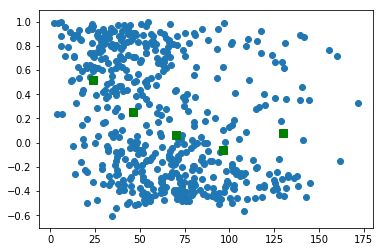

In [161]:
from scipy.cluster.vq import kmeans, vq
kmean_data = cs_stim_corr[['distance', 'corr_coeff']]
centroids, _ = kmeans(kmean_data, 5)
idx, _ = vq(kmean_data, centroids)

fig, ax = plt.subplots()
ax.scatter(cs_stim_corr.distance, cs_stim_corr.corr_coeff)
ax.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=8)
plt.show()

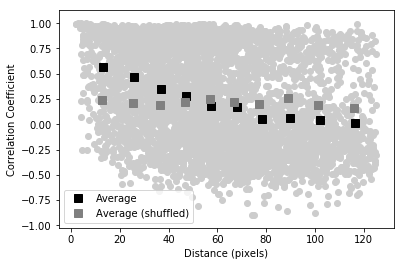

In [312]:
import ntpath
import random
color_pref_df_files = glob.glob('D:\\nhp_cells\\*color_pref_df.csv')
cs_stim_df_files = glob.glob('D:\\nhp_cells\\*cs_stim_df.csv')
cs_stim_corr_all = pd.DataFrame(columns=['cell_1', 'cell_2', 'corr_coeff', 'distance', 'analyzer'])
cs_stim_corr_shuff_all = pd.DataFrame(columns=['cell_1', 'cell_2', 'corr_coeff', 'distance', 'analyzer'])

for i, file in enumerate(color_pref_df_files):
    color_pref_ = pd.read_csv(file, index_col=0)
    cs_stim_file = cs_stim_df_files[i]
    cs_stim_ = pd.read_csv(cs_stim_df_files[i], index_col=0)
    
    cs_stim_shuff_ = cs_stim_.copy().as_matrix().T
    np.random.shuffle(cs_stim_shuff_)
    cs_stim_shuff_ = cs_stim_shuff_.T
    cs_stim_shuff_ = pd.DataFrame(cs_stim_shuff_, columns=cs_stim_.columns)
    # cs_stim_shuff_.columns = random.shuffle(list(cs_stim_shuff_))
    
    cs_stim_df_norm = (cs_stim_ - cs_stim_.mean()) / (cs_stim_.max() - cs_stim_.min())
    cs_stim_corr = cs_stim_df_norm.corr().where(np.triu(np.ones(cs_stim_df_norm.corr().shape)).astype(np.bool) == False)
    # cs_stim_corr = cs_stim_df.corr().where(np.triu(np.ones(cs_stim_df.corr().shape)).astype(np.bool) == False)
    cs_stim_corr = cs_stim_corr.stack().reset_index()
    cs_stim_corr.columns = ['cell_1', 'cell_2', 'corr_coeff']
    
    cs_stim_shuff_df_norm = (cs_stim_shuff_ - cs_stim_shuff_.mean()) / (cs_stim_shuff_.max() - cs_stim_shuff_.min())
    cs_stim_corr_shuff = cs_stim_shuff_df_norm.corr().where(np.triu(np.ones(cs_stim_shuff_df_norm.corr().shape)).astype(np.bool) == False)
    cs_stim_corr_shuff = cs_stim_corr_shuff.stack().reset_index()
    cs_stim_corr_shuff.columns = ['cell_1', 'cell_2', 'corr_coeff']
    
        
    def distance(x1, x2, y1, y2):
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    def cs_stim_distance(color_pref_, cs_stim_corr, file):
        x1 = color_pref_.loc[cs_stim_corr.cell_1.as_matrix().astype(int)].x.as_matrix().astype(float)
        y1 = color_pref_.loc[cs_stim_corr.cell_1.as_matrix().astype(int)].y.as_matrix().astype(float)
        x2 = color_pref_.loc[cs_stim_corr.cell_2.as_matrix().astype(int)].x.as_matrix().astype(float)
        y2 = color_pref_.loc[cs_stim_corr.cell_2.as_matrix().astype(int)].y.as_matrix().astype(float)
        cs_stim_corr['distance'] = distance(x1, x2, y1, y2)
        cs_stim_corr['analyzer'] = ntpath.basename(file)[0:8]
        return cs_stim_corr
    
    
    cs_stim_corr = cs_stim_distance(color_pref_, cs_stim_corr, file)
    cs_stim_corr_shuff = cs_stim_distance(color_pref_, cs_stim_corr_shuff, file)
        
    cs_stim_corr_all = cs_stim_corr_all.append(cs_stim_corr)
    cs_stim_corr_shuff_all = cs_stim_corr_shuff_all.append(cs_stim_corr_shuff)
    
cs_stim_corr_cut = cs_stim_corr_all[cs_stim_corr_all.distance < 125]
cs_stim_corr_shuff_cut = cs_stim_corr_shuff_all[cs_stim_corr_shuff_all.distance < 125]
    
from scipy.cluster.vq import kmeans, vq
kmean_data = cs_stim_corr_cut[['distance', 'corr_coeff']]
num_clusters = 10
centroids, _ = kmeans(kmean_data, num_clusters)
idx, _ = vq(kmean_data, centroids)

kmean_data_shuff = cs_stim_corr_shuff_cut[['distance', 'corr_coeff']]
centroids_shuff, _ = kmeans(kmean_data_shuff, num_clusters)
idx_shuff, _ = vq(kmean_data_shuff, centroids_shuff)

fig, ax = plt.subplots()
for i in range(num_clusters):
    ax.scatter(kmean_data.distance.iloc[idx==i], kmean_data.corr_coeff.iloc[idx==i], marker='o', color='0.8', label=None)
ax.plot(centroids[:, 0], centroids[:, 1], marker='s', color='k', markersize=8, linestyle='None', label='Average')
ax.plot(centroids_shuff[:, 0], centroids_shuff[:, 1], marker='s', color='0.5', markersize=8, linestyle='None', label='Average (shuffled)')
ax.set_xlabel('Distance (pixels)')
ax.set_ylabel('Correlation Coefficient')
plt.legend()
plt.savefig('D:/nhp_cells/distance_corr.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [4]:
import glob
allFiles = glob.glob('D:/nhp_cells/*color_pref_df.csv')
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
all_cells = pd.concat(list_)

In [5]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

v_resp_cell = all_cells[((all_cells.p_osi_ach < 0.001) & (all_cells.r_pref_ach > 0.03)) | 
                        ((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03))]
from scipy import stats
v_resp_cell = v_resp_cell[(np.abs(stats.zscore(v_resp_cell[['csi', 'osi_color', 'osi_ach']])) < 3).all(axis=1)]
v_resp_cell = v_resp_cell[(v_resp_cell.csi > -3) & (v_resp_cell.osi_ach > -3)]
v_resp_cell = v_resp_cell[(v_resp_cell.csi < 3) & (v_resp_cell.osi_ach < 3)]
fig, ax = plt.subplots()
ax.scatter(v_resp_cell.csi, v_resp_cell.osi_ach)
lim = 2
# ax.set_xlim([-lim, lim])
# ax.set_ylim([-lim, lim])

z_fit = np.polyfit(v_resp_cell.csi, v_resp_cell.osi_ach, 1)
p_fit = np.poly1d(z_fit)
ax.plot(v_resp_cell.csi, p_fit(v_resp_cell.csi), 'r--')
plt.show()


In [6]:
# Plot orientation selective cells
fig, ax = plt.subplots()
im = ax.scatter(v_resp_cell.x, v_resp_cell.y, s=50, c=v_resp_cell.osi_ach, 
                cmap='binary', edgecolors='k', vmin=0, vmax=1)
plt.show()
plt.close()

In [21]:
col_cells_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03) & (all_cells.csi > 0.7))]
ori_cells_strict = all_cells[((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02) & (all_cells.osi_ach > 0.3))]

col_ori_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03) & (all_cells.csi > 0.7)) & 
                           ((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02) & (all_cells.osi_ach > 0.3))]

In [29]:
col_ori_strict

,Unnamed: 0,cell,color_pref,csi,expt,max_color_response,ori_pref_ach,ori_pref_color,osi_ach,osi_color,p_color,p_osi_ach,p_osi_color,r_min_ach,r_min_color,r_pref_ach,r_pref_color,x,y
44,95,95.0,10.0,0.935280,u001_013,0.081542,135.0,135.0,1.009121,1.019404,4.785572e-05,1.584879e-04,6.929949e-15,-0.007287,-0.019272,0.798898,0.993186,200.0,109.0
60,120,120.0,14.0,1.037499,u001_013,0.365010,135.0,0.0,0.782758,0.102662,2.177859e-277,9.400823e-04,8.711783e-01,0.010099,0.398234,0.046485,0.480332,191.0,131.0
82,152,152.0,10.0,0.891882,u001_013,0.173991,0.0,45.0,0.732451,0.120151,4.090060e-115,1.904992e-03,7.594690e-03,0.003066,0.167832,0.125607,0.261099,145.0,158.0
94,173,173.0,12.0,0.563089,u001_013,0.220053,135.0,45.0,1.447304,0.922279,1.060515e-23,9.745063e-03,5.238952e-01,-0.024978,-0.015540,0.055841,0.704242,47.0,181.0
98,180,180.0,14.0,0.912013,u001_013,0.182850,0.0,90.0,0.929701,0.506509,2.495993e-65,4.799926e-03,2.264631e-01,-0.008858,0.192987,0.035889,0.391333,92.0,186.0
99,184,184.0,11.0,0.976335,u001_013,0.047273,90.0,90.0,0.933141,0.751625,6.170735e-15,4.076935e-05,4.613819e-08,-0.001304,-0.001313,0.151995,0.217571,163.0,192.0
110,203,203.0,17.0,0.764529,u001_013,0.100352,0.0,0.0,0.851854,0.143376,3.596041e-12,8.728154e-03,1.154954e-01,0.002277,0.056354,0.040625,0.169906,92.0,218.0
127,279,279.0,10.0,0.919861,u001_013,0.051421,135.0,135.0,1.016806,0.968537,7.898121e-04,1.173629e-04,2.069749e-12,-0.008646,0.001333,0.514441,0.613901,198.0,103.5
140,313,313.0,10.0,0.967787,u001_013,0.239959,135.0,135.0,1.032343,0.832330,5.191490e-54,6.877885e-07,1.257582e-18,-0.004427,0.085618,0.136867,0.736270,150.0,143.0
148,326,326.0,10.0,0.992824,u001_013,0.101784,0.0,45.0,0.531678,0.337217,1.782598e-84,3.325614e-03,1.359366e-01,-0.013282,0.109413,0.059793,0.173464,142.0,163.0


In [26]:
col_ori_strict = all_cells[((all_cells.p_color < 0.001) & (all_cells.max_color_response > 0.03)) & 
                           ((all_cells.p_osi_ach < 0.01) & (all_cells.r_pref_ach > 0.02))]

In [5]:
cell_F_stim_color[cell_F_stim_color.Color == 13]

,Orientation,Direction,Spatial Frequency,Color,Mean
200,90.0,270.0,0.8,13.0,0.003772
201,0.0,0.0,0.8,13.0,-0.023687
224,45.0,225.0,0.8,13.0,-0.040724
227,135.0,135.0,1.6,13.0,-0.018486
228,135.0,315.0,0.8,13.0,0.155882
236,90.0,270.0,0.2,13.0,0.265533
257,0.0,180.0,0.8,13.0,0.160979
260,45.0,45.0,0.2,13.0,-0.008911
262,90.0,90.0,0.2,13.0,-0.170059
290,0.0,180.0,0.2,13.0,-0.056774
